<h1>LSTM remove outlier with zscore</h1>

In [71]:
import numpy as np
from numpy import log, exp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from IPython.core.interactiveshell import InteractiveShell

# LSTM
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.svm import OneClassSVM
from tensorflow.keras.layers import Dropout, LSTM, Dense, RepeatVector, TimeDistributed
from tensorflow.keras.models import Sequential
from keras.callbacks import EarlyStopping
from sklearn.model_selection import ParameterSampler
from scipy.stats import skew


InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline
sns.set()
pd.options.display.max_rows = 100


<h4>Importing Datasets</h4>

In [72]:
# Import dataset and clean, ready as a dataframe for creating keys
def createDF(datasets):
    df = pd.read_csv(datasets, converters={
                     'PARTY_ID': str, 'COM_ID': str, 'CNTR_SIZE': str})

    # Formating to type and remove NaN values
    df['POD'] = pd.to_datetime(df['POD'])
    df['ENCODED_TYPE'] = df['ENCODED_TYPE'].fillna(-1).astype(int)
    df = df.dropna(subset=['ENCODED_TYPE'])
    df['RATE'] = df['RATE'].fillna(-1).astype(float)
    df = df.dropna(subset=['RATE'])
    df['ENCODED_TYPE'] = df['ENCODED_TYPE'].astype(int)
    df_clean = df.dropna().reset_index(drop=True)

    # Selecting and rearranging columns
    sel_col = ['CSL_ID', 'CNTR_ID', 'POD_ID', 'ETD_POL_D', 'PARTY_ID',
               'PARTY_NAME', 'POD', 'CNTR_SIZE', 'CNTR_TYPE', 'RATE']
    df_fc = df_clean[sel_col]

    # Removing years we do not want to process in our models
    df_filtered = df_fc[df_fc['POD'].dt.year != 2002]

    # Sorting the dates
    df_filtered = df_filtered.sort_values(by='POD').reset_index(drop=True)

    return df_filtered


In [73]:
# Create Dataframes for old and new
old_data = '.\Datasets\CR_COST_FC.csv'
df1 = createDF(old_data)
df1.head()

new_data = '.\Datasets\CR_COST_FC_new.csv'
df2 = createDF(new_data)
df2.head()


,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
0,ECS01050600224,CTNR010050700354,ROTTERDAM,NLRTM,01008827,YANG MING (SINGAPORE) PTE. LTD.,2005-07-15,40,HC NOR,1620.0
1,ECS01050600610,CTNR010050700353,FELIXSTOWE,GBFXT,01002303,GLOBELINK FALLOW LIMITED,2005-07-15,40,GP,1800.0
2,ECS01050600041,CTNR010050700351,AUCKLAND,NZAKL,01005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2005-07-15,40,HC NOR,2170.0
3,ECS01050600163,CTNR010050700370,PASIR GUDANG,MYPGU,01002767,GLOBELINK CONTAINER LINES (JB) S/B,2005-07-15,40,HC,280.0
4,ECS01050600456,CTNR010050700450,KARACHI (KICT),PKKHI,01002783,GLOBELINK PAKISTAN (PVT) LTD,2005-07-16,40,HC,1625.0


,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
0,ECS01050600224,CTNR010050700354,ROTTERDAM,NLRTM,01008827,YANG MING (SINGAPORE) PTE. LTD.,2005-07-15,40,HC NOR,1620.0
1,ECS01050600610,CTNR010050700353,FELIXSTOWE,GBFXT,01002303,GLOBELINK FALLOW LIMITED,2005-07-15,40,GP,1800.0
2,ECS01050600041,CTNR010050700351,AUCKLAND,NZAKL,01005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2005-07-15,40,HC NOR,2170.0
3,ECS01050600163,CTNR010050700370,PASIR GUDANG,MYPGU,01002767,GLOBELINK CONTAINER LINES (JB) S/B,2005-07-15,40,HC,280.0
4,ECS01050600456,CTNR010050700450,KARACHI (KICT),PKKHI,01002783,GLOBELINK PAKISTAN (PVT) LTD,2005-07-16,40,HC,1625.0


<h4>Creating Dictionary Keys</h4>

In [74]:
def filter_dataframe(df):
    filtered_dataframes = {}

    for (port, size, ctype, party_id), group in df.groupby(['POD_ID', 'CNTR_SIZE', 'CNTR_TYPE', 'PARTY_ID']):
        group = group.reset_index(drop=True).sort_values(by='POD')
        df_id = f"Port_{port}_Size_{size}_Type_{ctype}_PartyID_{party_id}"
        filtered_dataframes[df_id] = group

    return filtered_dataframes


In [75]:
# Creating keys from data
print("Old Data keys:")
filtered_dataframe1 = filter_dataframe(df1)
df_ids1 = list(filtered_dataframe1.keys())
print(list(df_ids1))
print(len(list(df_ids1)))

print("\nNew Data keys:")
filtered_dataframe2 = filter_dataframe(df2)
df_ids2 = list(filtered_dataframe2.keys())
print(list(df_ids2))
print(len(list(df_ids2)))


Old Data keys:
['Port_(CONSTANZA)_Size_40_Type_GP_PartyID_010007816', 'Port_(CONSTANZA)_Size_40_Type_HC_PartyID_010007816', 'Port_AARHUS_Size_20_Type_GP_PartyID_01000043', 'Port_AARHUS_Size_20_Type_GP_PartyID_0100027830', 'Port_AARHUS_Size_20_Type_GP_PartyID_010006666', 'Port_AARHUS_Size_40_Type_GP_PartyID_01000043', 'Port_AARHUS_Size_40_Type_HC_PartyID_01000043', 'Port_AARHUS_Size_40_Type_HC_PartyID_0100027830', 'Port_AARHUS_Size_40_Type_HC_PartyID_0100028193', 'Port_AARHUS_Size_40_Type_HC_PartyID_010006666', 'Port_ABIDJAN_Size_20_Type_GP_PartyID_0100027878', 'Port_ABIDJAN_Size_40_Type_HC_PartyID_010021097', 'Port_ADELAIDE_Size_20_Type_GP_PartyID_01002775', 'Port_ADELAIDE_Size_40_Type_GP_PartyID_01002775', 'Port_ADELAIDE_Size_40_Type_HC_PartyID_01002775', 'Port_ADELAIDE_Size_40_Type_HC_PartyID_01005078', 'Port_ADELAIDE_Size_40_Type_HC NOR_PartyID_01002775', 'Port_ADELAIDE(AU)_Size_20_Type_GP_PartyID_01002775', 'Port_ADELAIDE(AU)_Size_40_Type_HC_PartyID_01002775', 'Port_ADELAIDE(AU)_Si

<h4>Getting Top 5 ports keys</h4>

In [76]:
def getTop5Ports(keybunch):
    keybunch_pouch = []

    # Get a dictionary with key and number of rows for each dataframe in filtered_dataframes
    key_row_counts = {key: len(keybunch[key]) for key in keybunch}

    # Sort the key_row_counts dictionary by value (number of rows) in descending order
    sorted_key_row_counts = sorted(
        key_row_counts.items(), key=lambda item: item[1], reverse=True)

    # Get the top 5 keys with the most rows
    top_5_keys_tuple = sorted_key_row_counts[:5]

    # Create a dictionary with the top 5 keys and their corresponding dataframes (with up to 5 rows per dataframe)
    keybunch_subset = {}

    for key, row_count in top_5_keys_tuple:
        keybunch_subset[key] = keybunch[key][:5]
        print(f"Number of rows in {key}: {row_count}")
        keybunch_pouch.append(key)

    # Return array of keys
    return keybunch_pouch


In [77]:
print('Old Dataset Keybunch:')
old_df = getTop5Ports(filtered_dataframe1)
print('\n')

print('New Dataset Keybunch:')
new_df = getTop5Ports(filtered_dataframe2)


Old Dataset Keybunch:
Number of rows in Port_BUSAN_Size_40_Type_HC_PartyID_010004286: 1689
Number of rows in Port_AUCKLAND_Size_40_Type_HC_PartyID_01005136: 1688
Number of rows in Port_MELBOURNE_Size_40_Type_HC_PartyID_01002778: 1325
Number of rows in Port_SYDNEY_Size_40_Type_HC_PartyID_01002779: 1300
Number of rows in Port_DUBAI (JEBEL ALI)_Size_40_Type_HC_PartyID_01002788: 1052


New Dataset Keybunch:
Number of rows in Port_BUSAN_Size_40_Type_HC_PartyID_010004286: 1712
Number of rows in Port_AUCKLAND_Size_40_Type_HC_PartyID_01005136: 1704
Number of rows in Port_MELBOURNE_Size_40_Type_HC_PartyID_01002778: 1341
Number of rows in Port_SYDNEY_Size_40_Type_HC_PartyID_01002779: 1308
Number of rows in Port_DUBAI (JEBEL ALI)_Size_40_Type_HC_PartyID_01002788: 1070


In [78]:
# Global selection
sel_country = old_df[2]

# Accessing the highest count in the each keypouch, new and old.
sel_df = filtered_dataframe1[sel_country]
sel_df.head(5)
sel_df.tail(5)
sel_df.info()
print("\n")

latest_sel_df = filtered_dataframe2[sel_country]
latest_sel_df.head(5)
latest_sel_df.tail(5)
latest_sel_df.info()


,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
0,ECS01050600278,CTNR010050700692,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2005-07-23,40,HC,1200.0
1,ECS01050600280,CTNR010050701022,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2005-07-30,40,HC,1200.0
2,ECS010050700458,CTNR010050800604,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2005-08-16,40,HC,1000.0
3,ECS010050700214,CTNR010050800727,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2005-08-19,40,HC,1200.0
4,ECS010050900271,CTNR010051000178,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2005-10-11,40,HC,900.0


,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
1320,ECS010230100302,010000357415,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2023-02-11,40,HC,1200.0
1321,ECS010230100303,010000380481,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2023-02-16,40,HC,1200.0
1323,ECS010230100304,010000392586,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2023-02-24,40,HC,1200.0
1322,ECS010230100304,010000390964,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2023-02-24,40,HC,1200.0
1324,ECS010230100304,010000399293,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2023-02-24,40,HC,1200.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1325 entries, 0 to 1324
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   CSL_ID      1325 non-null   object        
 1   CNTR_ID     1325 non-null   object        
 2   POD_ID      1325 non-null   object        
 3   ETD_POL_D   1325 non-null   object        
 4   PARTY_ID    1325 non-null   object        
 5   PARTY_NAME  1325 non-null   object        
 6   POD         1325 non-null   datetime64[ns]
 7   CNTR_SIZE   1325 non-null   object        
 8   CNTR_TYPE   1325 non-null   object        
 9   RATE        1325 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(8)
memory usage: 113.9+ KB




,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
0,ECS01050600278,CTNR010050700692,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2005-07-23,40,HC,1200.0
1,ECS01050600280,CTNR010050701022,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2005-07-30,40,HC,1200.0
2,ECS010050700458,CTNR010050800604,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2005-08-16,40,HC,1000.0
3,ECS010050700214,CTNR010050800727,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2005-08-19,40,HC,1200.0
4,ECS010050900271,CTNR010051000178,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2005-10-11,40,HC,900.0


,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
1336,ECS010230300518,010000531211,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2023-04-28,40,HC,500.0
1337,ECS010230300518,010000509487,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2023-04-28,40,HC,500.0
1338,ECS010230400431,010000541165,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2023-05-05,40,HC,500.0
1339,ECS010230400432,010000543217,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2023-05-11,40,HC,500.0
1340,ECS010230400433,010000557443,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2023-05-19,40,HC,400.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1341 entries, 0 to 1340
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   CSL_ID      1341 non-null   object        
 1   CNTR_ID     1341 non-null   object        
 2   POD_ID      1341 non-null   object        
 3   ETD_POL_D   1341 non-null   object        
 4   PARTY_ID    1341 non-null   object        
 5   PARTY_NAME  1341 non-null   object        
 6   POD         1341 non-null   datetime64[ns]
 7   CNTR_SIZE   1341 non-null   object        
 8   CNTR_TYPE   1341 non-null   object        
 9   RATE        1341 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(8)
memory usage: 115.2+ KB


In [79]:
# Select features
sel_feat = ['POD', 'RATE']
# make a copy to avoid SettingWithCopyWarning
sel_feat_df = sel_df[sel_feat].copy()


<Figure size 2000x1000 with 0 Axes>

Text(0.5, 0, 'Date(Year Month Week)')

Text(0, 0.5, 'Cost Rate(USD)')

Text(0.5, 1.0, 'Port_MELBOURNE_Size_40_Type_HC_PartyID_01002778')

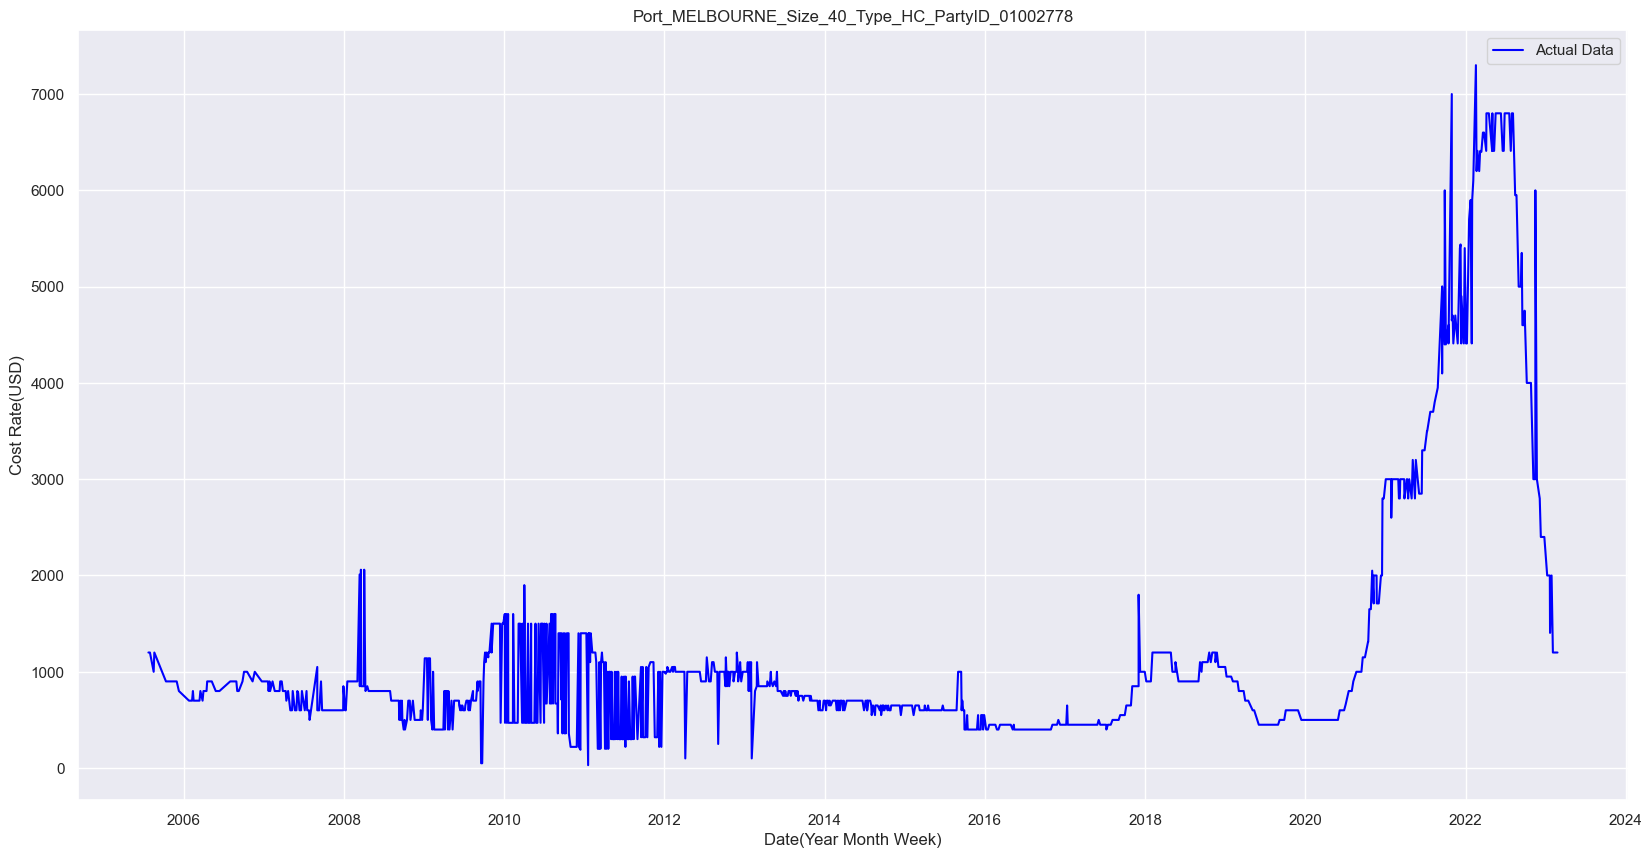

In [80]:
plt.figure(figsize=(20, 10))
plt.plot(sel_feat_df['POD'], sel_feat_df['RATE'],
         color='blue', label="Actual Data")

plt.xlabel('Date(Year Month Week)')
plt.ylabel('Cost Rate(USD)')
plt.title(sel_country)
plt.legend()
plt.show()


<h4>Detect and Remove Outliers</h4>

In [81]:
# Assuming 'robust_df' is your DataFrame and 'RATE' is the column containing the data
z_scores = stats.zscore(sel_feat_df[['RATE']])
threshold = 3  # Z-score threshold for outlier detection

# Find indices of outliers
outlier_indices = np.where(np.abs(z_scores) > threshold)[0]

# Remove outliers
robust_df = sel_feat_df.drop(sel_feat_df.index[outlier_indices])

# Reset the index
robust_df.reset_index(drop=True, inplace=True)

# Print the modified DataFrame
robust_df.head()
robust_df.info()


,POD,RATE
0,2005-07-23,1200.0
1,2005-07-30,1200.0
2,2005-08-16,1000.0
3,2005-08-19,1200.0
4,2005-10-11,900.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1275 entries, 0 to 1274
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   POD     1275 non-null   datetime64[ns]
 1   RATE    1275 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 20.0 KB


<Figure size 2000x1000 with 0 Axes>

Text(0.5, 0, 'Date(Year Month Week)')

Text(0, 0.5, 'Cost Rate(USD)')

Text(0.5, 1.0, 'Port_MELBOURNE_Size_40_Type_HC_PartyID_01002778')

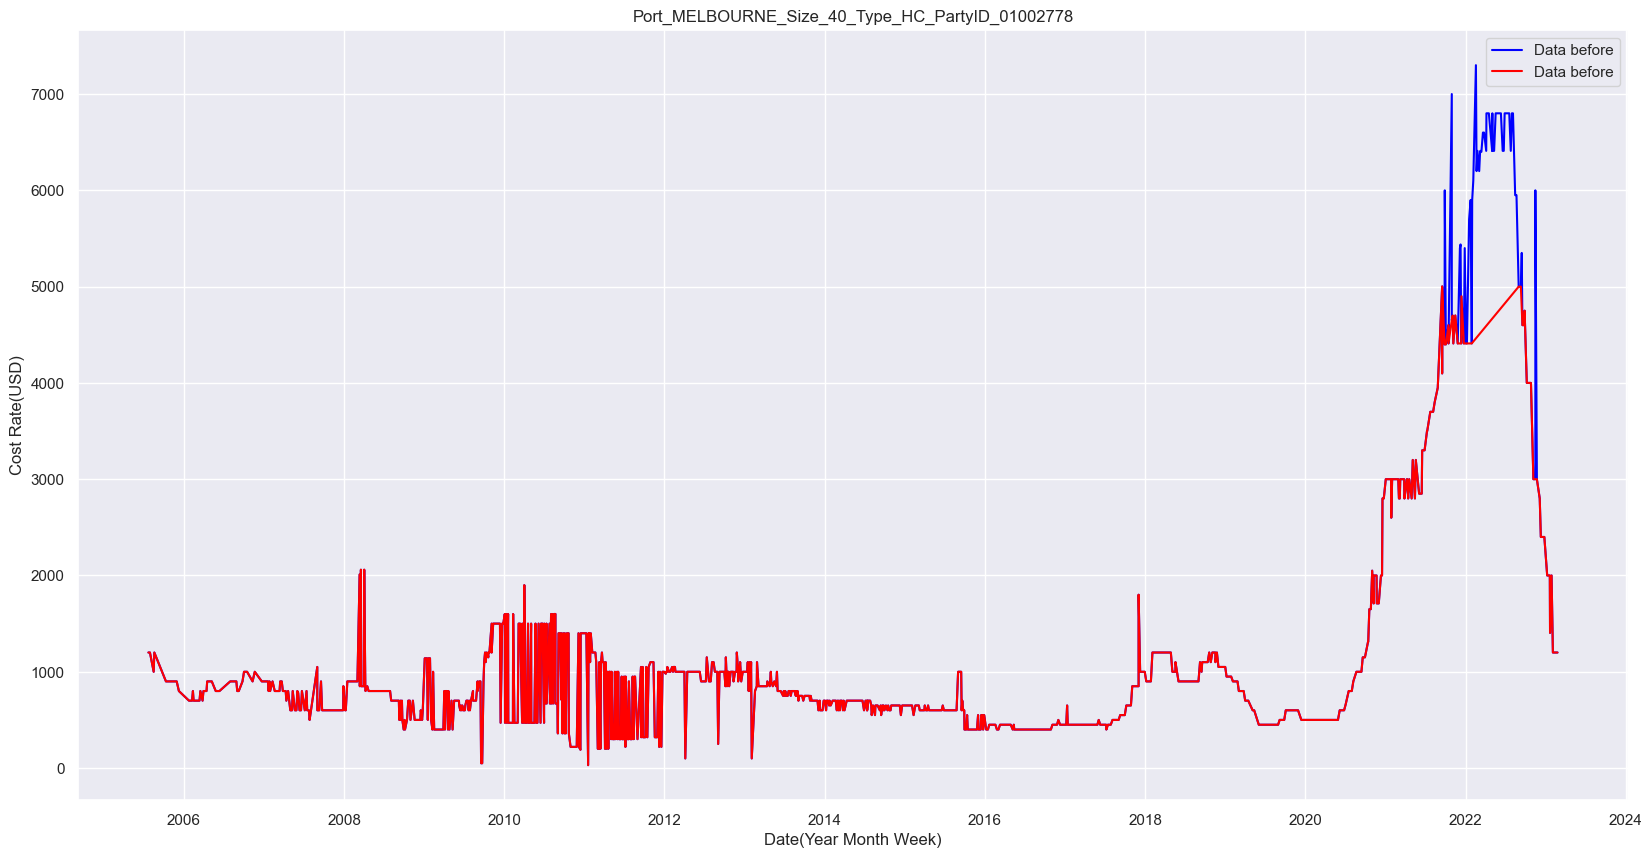

In [82]:
plt.figure(figsize=(20, 10))
plt.plot(sel_feat_df['POD'], sel_feat_df['RATE'],
         color='blue', label="Data before")
plt.plot(robust_df['POD'], robust_df['RATE'], color='red', label="Data before")

plt.xlabel('Date(Year Month Week)')
plt.ylabel('Cost Rate(USD)')
plt.title(sel_country)
plt.legend()
plt.show()


<h4>Interpolate missing values in between dates</h4>

In [83]:
# Remove duplicated dates and cost rows
robust_df = robust_df.drop_duplicates(
    subset=['POD', 'RATE']).reset_index(drop=True)

# Create a new dataframe with a date range from min to max date in your dataframe
new_df = pd.DataFrame()
new_df['POD'] = pd.date_range(
    start=robust_df['POD'].min(), end=robust_df['POD'].max())

# Merge the original dataframe with the new one. Missing dates in the original dataframe will be filled with NaN
df_interpolated = pd.merge(new_df, robust_df, on='POD', how='left')

# Perform spline interpolation
df_interpolated['RATE'] = df_interpolated['RATE'].interpolate(
    method='polynomial', order=1)

df_interpolated['RATE'] = df_interpolated['RATE'].round(3)

df_interpolated.head(5)
df_interpolated.tail(5)
df_interpolated.info()


,POD,RATE
0,2005-07-23,1200.0
1,2005-07-24,1200.0
2,2005-07-25,1200.0
3,2005-07-26,1200.0
4,2005-07-27,1200.0


,POD,RATE
6438,2023-02-20,1200.0
6439,2023-02-21,1200.0
6440,2023-02-22,1200.0
6441,2023-02-23,1200.0
6442,2023-02-24,1200.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6443 entries, 0 to 6442
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   POD     6443 non-null   datetime64[ns]
 1   RATE    6443 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 151.0 KB


<h4>Grouping it to week</h4>

In [84]:
# Create YearMonthWeek directly from the 'POD'
df_interpolated['YearMonthWeek'] = df_interpolated['POD'] - \
    pd.to_timedelta(df_interpolated['POD'].dt.dayofweek, unit='D')

# Create a new dataframe with every week in the range
all_weeks = pd.date_range(start=df_interpolated['POD'].min(
), end=df_interpolated['POD'].max(), freq='W')
all_weeks_df = pd.DataFrame(all_weeks, columns=['POD'])

# Create YearMonthWeek in all_weeks_df
all_weeks_df['YearMonthWeek'] = all_weeks_df['POD'] - \
    pd.to_timedelta(all_weeks_df['POD'].dt.dayofweek, unit='D')

# Merge this with your original dataframe
merged_df = pd.merge(all_weeks_df, df_interpolated,
                     on=['YearMonthWeek'], how='left')

# Now you can group by YearMonthWeek and compute your rate
grouped = merged_df.groupby(['YearMonthWeek'])

agg_df = pd.DataFrame(columns=['YearMonthWeek', 'Rate'])

for group_name, group_df in grouped:
    year_month_week = group_name

    # Skip if no data for this week
    if group_df['RATE'].isnull().all():
        continue

    # Calculate sum and skewness of RATE values
    rate_sum = group_df['RATE'].sum()
    rate_skew = group_df['RATE'].skew()

    # Calculate trimmed mean of RATE values
    # trimming 10% from each end
    rate_metric = stats.trim_mean(group_df['RATE'].dropna().values, 0.1)

    new_row = {
        'YearMonthWeek': year_month_week,
        'Rate': rate_metric
    }

    # Append row to aggregated dataframe
    agg_df = agg_df.append(new_row, ignore_index=True)

agg_df = agg_df.sort_values(by='YearMonthWeek').reset_index(drop=True)
agg_df['Rate'] = agg_df['Rate'].round(2)

agg_df.head(15)
agg_df.tail(15)
agg_df.info()


C:\Users\Aloysius Wong\AppData\Local\Temp\ipykernel_43872\2707369425.py:23: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for group_name, group_df in grouped:
C:\Users\Aloysius Wong\AppData\Local\Temp\ipykernel_43872\2707369425.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  agg_df = agg_df.append(new_row, ignore_index=True)
C:\Users\Aloysius Wong\AppData\Local\Temp\ipykernel_43872\2707369425.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  agg_df = agg_df.append(new_row, ignore_index=True)
C:\Users\Aloysius Wong\AppData\Local\Temp\ipykernel_43872\2707369425.py:44: FutureWarning: The frame.append method is deprecated and will be r

,YearMonthWeek,Rate
0,2005-07-18,1200.00
1,2005-07-25,1198.32
2,2005-08-01,1141.18
3,2005-08-08,1058.82
4,2005-08-15,1113.54
5,2005-08-22,1166.04
6,2005-08-29,1126.42
7,2005-09-05,1086.79
8,2005-09-12,1047.17
9,2005-09-19,1007.55


,YearMonthWeek,Rate
903,2022-11-07,3000.00
904,2022-11-14,3000.00
905,2022-11-21,2967.03
906,2022-11-28,2861.54
907,2022-12-05,2571.43
908,2022-12-12,2400.00
909,2022-12-19,2400.00
910,2022-12-26,2307.69
911,2023-01-02,2092.31
912,2023-01-09,2000.00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   YearMonthWeek  918 non-null    datetime64[ns]
 1   Rate           918 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 14.5 KB


<h4>Latest datapoints from Latest dataframe for comparing after forecasting (Measure accuracy)</h4>

In [85]:
max_date_in_old = sel_df['POD'].max()

# Create a new dataframe that only includes rows from the latest dataframe where the date is greater than the maximum date in the old dataframe
new_dates_df = latest_sel_df[latest_sel_df['POD']
                             > max_date_in_old].reset_index(drop=True)

# Print the new dataframe
new_dates_df.head(3)
new_dates_df.tail(3)
new_dates_df.info()


,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
0,ECS010230200328,010000409869,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2023-03-02,40,HC,1000.0
1,ECS010230200329,010000419018,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2023-03-10,40,HC,1000.0
2,ECS010230200330,010000427048,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2023-03-16,40,HC,1000.0


,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
13,ECS010230400431,010000541165,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2023-05-05,40,HC,500.0
14,ECS010230400432,010000543217,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2023-05-11,40,HC,500.0
15,ECS010230400433,010000557443,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2023-05-19,40,HC,400.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   CSL_ID      16 non-null     object        
 1   CNTR_ID     16 non-null     object        
 2   POD_ID      16 non-null     object        
 3   ETD_POL_D   16 non-null     object        
 4   PARTY_ID    16 non-null     object        
 5   PARTY_NAME  16 non-null     object        
 6   POD         16 non-null     datetime64[ns]
 7   CNTR_SIZE   16 non-null     object        
 8   CNTR_TYPE   16 non-null     object        
 9   RATE        16 non-null     float64       
dtypes: datetime64[ns](1), float64(1), object(8)
memory usage: 1.4+ KB


<Figure size 2000x1000 with 0 Axes>

Text(0.5, 0, 'Date(Year Month Week)')

Text(0, 0.5, 'Cost Rate(USD)')

Text(0.5, 1.0, 'Port_MELBOURNE_Size_40_Type_HC_PartyID_01002778')

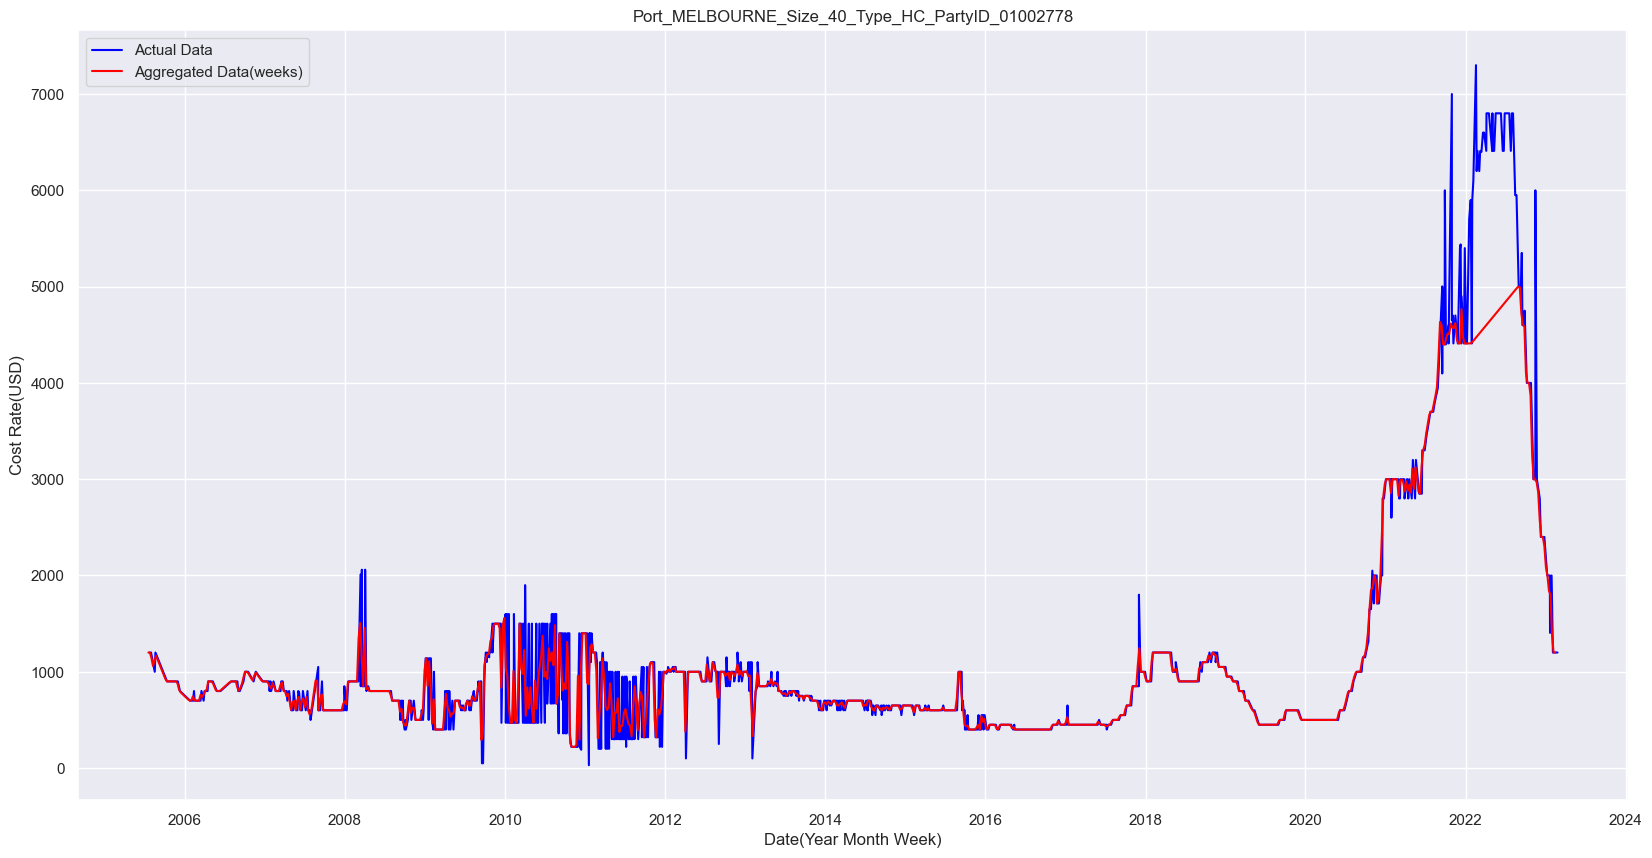

In [86]:
plt.figure(figsize=(20, 10))
plt.plot(sel_df['POD'], sel_df['RATE'], color='blue', label="Actual Data")
plt.plot(agg_df['YearMonthWeek'], agg_df['Rate'],
         color='red', label="Aggregated Data(weeks)")

plt.xlabel('Date(Year Month Week)')
plt.ylabel('Cost Rate(USD)')
plt.title(sel_country)
plt.legend()
plt.show()


<h4>LSTM Regression<h4>

In [87]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# Mean Square Error Function:


def calculate_RMSE(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Update create_dataset to handle multi-feature dataset


def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)


def create_LSTM_model(trainX, trainY, testX, testY, epochs, lstm_layers):
    model = Sequential()

    for i in range(len(lstm_layers)):
        if i == 0:
            # First layer specifies the input_shape and returns sequences
            model.add(LSTM(lstm_layers[i], return_sequences=True, input_shape=(look_back, trainX.shape[2]),
                           activation='tanh', recurrent_activation='hard_sigmoid', kernel_regularizer=l2(0.01)))
        elif i == len(lstm_layers) - 1:
            # Last layer doesn't return sequences
            model.add(
                LSTM(lstm_layers[i], activation='tanh', kernel_regularizer=l2(0.01)))
        else:
            # Middle layers return sequences
            model.add(LSTM(lstm_layers[i], return_sequences=True, activation='tanh',
                           recurrent_activation='hard_sigmoid', kernel_regularizer=l2(0.01)))
        model.add(Dropout(0.2))

    model.add(Dense(1))
    model.compile(loss='mean_squared_error',
                  optimizer=Adam(learning_rate=0.0005))
    model.summary()

    # Add early stopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

    # Fit the model and store the history
    history = model.fit(trainX, trainY, epochs=epochs, batch_size=128, verbose=2,
                        validation_data=(testX, testY), callbacks=[es])
    return model, history

# Normalize dataset for LSTM using log transformation


def normalize_data_log(data):
    # Adding 1 to avoid division by zero in log transformation
    return log(data + 1)


def inverse_normalize_data_log(data):
    return exp(data) - 1  # Subtracting 1 to get original data


def plot_train_val_loss(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model loss progress during training and validation')
    plt.xlabel('Epoch')
    plt.ylabel('Training and Validation Loss')
    plt.legend()
    plt.show()


Training for 50 epochs...
Training with LSTM layers: [64, 64, 32, 32, 16, 16, 8, 8, 4, 4, 2, 2]
Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_336 (LSTM)             (None, 5, 64)             16896     
                                                                 
 dropout_336 (Dropout)       (None, 5, 64)             0         
                                                                 
 lstm_337 (LSTM)             (None, 5, 64)             33024     
                                                                 
 dropout_337 (Dropout)       (None, 5, 64)             0         
                                                                 
 lstm_338 (LSTM)             (None, 5, 32)             12416     
                                                                 
 dropout_338 (Dropout)       (None, 5, 32)             0         
                       

9/9 [==============================] - 0s 6ms/step
Train Score: 765.06 RMSE for 50 epochs
Test Score: 2629.81 RMSE for 50 epochs
Training with LSTM layers: [32, 32, 16, 16, 8, 8, 4, 4, 2, 2]
Model: "sequential_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_348 (LSTM)             (None, 5, 32)             4352      
                                                                 
 dropout_348 (Dropout)       (None, 5, 32)             0         
                                                                 
 lstm_349 (LSTM)             (None, 5, 32)             8320      
                                                                 
 dropout_349 (Dropout)       (None, 5, 32)             0         
                                                                 
 lstm_350 (LSTM)             (None, 5, 16)             3136      
                                                            

9/9 [==============================] - 0s 5ms/step
Train Score: 768.09 RMSE for 50 epochs
Test Score: 2632.36 RMSE for 50 epochs
Training with LSTM layers: [16, 16, 8, 8, 4, 4, 2, 2]
Model: "sequential_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_358 (LSTM)             (None, 5, 16)             1152      
                                                                 
 dropout_358 (Dropout)       (None, 5, 16)             0         
                                                                 
 lstm_359 (LSTM)             (None, 5, 16)             2112      
                                                                 
 dropout_359 (Dropout)       (None, 5, 16)             0         
                                                                 
 lstm_360 (LSTM)             (None, 5, 8)              800       
                                                                 
 d

9/9 [==============================] - 0s 4ms/step
Train Score: 768.42 RMSE for 50 epochs
Test Score: 2632.62 RMSE for 50 epochs
Training with LSTM layers: [8, 8, 4, 4, 2, 2]
Model: "sequential_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_366 (LSTM)             (None, 5, 8)              320       
                                                                 
 dropout_366 (Dropout)       (None, 5, 8)              0         
                                                                 
 lstm_367 (LSTM)             (None, 5, 8)              544       
                                                                 
 dropout_367 (Dropout)       (None, 5, 8)              0         
                                                                 
 lstm_368 (LSTM)             (None, 5, 4)              208       
                                                                 
 dropout_3

9/9 [==============================] - 0s 3ms/step
Train Score: 767.99 RMSE for 50 epochs
Test Score: 2632.27 RMSE for 50 epochs
Training with LSTM layers: [4, 4, 2, 2]
Model: "sequential_52"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_372 (LSTM)             (None, 5, 4)              96        
                                                                 
 dropout_372 (Dropout)       (None, 5, 4)              0         
                                                                 
 lstm_373 (LSTM)             (None, 5, 4)              144       
                                                                 
 dropout_373 (Dropout)       (None, 5, 4)              0         
                                                                 
 lstm_374 (LSTM)             (None, 5, 2)              56        
                                                                 
 dropout_374 (Dr

9/9 [==============================] - 0s 2ms/step
Train Score: 768.13 RMSE for 50 epochs
Test Score: 2632.39 RMSE for 50 epochs
Training with LSTM layers: [2, 2]
Model: "sequential_53"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_376 (LSTM)             (None, 5, 2)              32        
                                                                 
 dropout_376 (Dropout)       (None, 5, 2)              0         
                                                                 
 lstm_377 (LSTM)             (None, 2)                 40        
                                                                 
 dropout_377 (Dropout)       (None, 2)                 0         
                                                                 
 dense_53 (Dense)            (None, 1)                 3         
                                                                 
Total params: 75
Train

9/9 [==============================] - 0s 1ms/step
Train Score: 768.87 RMSE for 50 epochs
Test Score: 2633.00 RMSE for 50 epochs
Training for 100 epochs...
Training with LSTM layers: [64, 64, 32, 32, 16, 16, 8, 8, 4, 4, 2, 2]
Model: "sequential_54"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_378 (LSTM)             (None, 5, 64)             16896     
                                                                 
 dropout_378 (Dropout)       (None, 5, 64)             0         
                                                                 
 lstm_379 (LSTM)             (None, 5, 64)             33024     
                                                                 
 dropout_379 (Dropout)       (None, 5, 64)             0         
                                                                 
 lstm_380 (LSTM)             (None, 5, 32)             12416     
                         

9/9 [==============================] - 0s 6ms/step
Train Score: 760.00 RMSE for 100 epochs
Test Score: 2625.58 RMSE for 100 epochs
Training with LSTM layers: [32, 32, 16, 16, 8, 8, 4, 4, 2, 2]
Model: "sequential_55"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_390 (LSTM)             (None, 5, 32)             4352      
                                                                 
 dropout_390 (Dropout)       (None, 5, 32)             0         
                                                                 
 lstm_391 (LSTM)             (None, 5, 32)             8320      
                                                                 
 dropout_391 (Dropout)       (None, 5, 32)             0         
                                                                 
 lstm_392 (LSTM)             (None, 5, 16)             3136      
                                                          

9/9 [==============================] - 0s 4ms/step
Train Score: 762.70 RMSE for 100 epochs
Test Score: 2627.84 RMSE for 100 epochs
Training with LSTM layers: [16, 16, 8, 8, 4, 4, 2, 2]
Model: "sequential_56"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_400 (LSTM)             (None, 5, 16)             1152      
                                                                 
 dropout_400 (Dropout)       (None, 5, 16)             0         
                                                                 
 lstm_401 (LSTM)             (None, 5, 16)             2112      
                                                                 
 dropout_401 (Dropout)       (None, 5, 16)             0         
                                                                 
 lstm_402 (LSTM)             (None, 5, 8)              800       
                                                                 


9/9 [==============================] - 0s 4ms/step
Train Score: 764.73 RMSE for 100 epochs
Test Score: 2629.54 RMSE for 100 epochs
Training with LSTM layers: [8, 8, 4, 4, 2, 2]
Model: "sequential_57"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_408 (LSTM)             (None, 5, 8)              320       
                                                                 
 dropout_408 (Dropout)       (None, 5, 8)              0         
                                                                 
 lstm_409 (LSTM)             (None, 5, 8)              544       
                                                                 
 dropout_409 (Dropout)       (None, 5, 8)              0         
                                                                 
 lstm_410 (LSTM)             (None, 5, 4)              208       
                                                                 
 dropout

9/9 [==============================] - 0s 3ms/step
Train Score: 767.42 RMSE for 100 epochs
Test Score: 2631.79 RMSE for 100 epochs
Training with LSTM layers: [4, 4, 2, 2]
Model: "sequential_58"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_414 (LSTM)             (None, 5, 4)              96        
                                                                 
 dropout_414 (Dropout)       (None, 5, 4)              0         
                                                                 
 lstm_415 (LSTM)             (None, 5, 4)              144       
                                                                 
 dropout_415 (Dropout)       (None, 5, 4)              0         
                                                                 
 lstm_416 (LSTM)             (None, 5, 2)              56        
                                                                 
 dropout_416 (

9/9 [==============================] - 0s 3ms/step
Train Score: 764.59 RMSE for 100 epochs
Test Score: 2629.42 RMSE for 100 epochs
Training with LSTM layers: [2, 2]
Model: "sequential_59"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_418 (LSTM)             (None, 5, 2)              32        
                                                                 
 dropout_418 (Dropout)       (None, 5, 2)              0         
                                                                 
 lstm_419 (LSTM)             (None, 2)                 40        
                                                                 
 dropout_419 (Dropout)       (None, 2)                 0         
                                                                 
 dense_59 (Dense)            (None, 1)                 3         
                                                                 
Total params: 75
Tra

9/9 [==============================] - 0s 2ms/step
Train Score: 764.99 RMSE for 100 epochs
Test Score: 2629.74 RMSE for 100 epochs
Training for 150 epochs...
Training with LSTM layers: [64, 64, 32, 32, 16, 16, 8, 8, 4, 4, 2, 2]
Model: "sequential_60"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_420 (LSTM)             (None, 5, 64)             16896     
                                                                 
 dropout_420 (Dropout)       (None, 5, 64)             0         
                                                                 
 lstm_421 (LSTM)             (None, 5, 64)             33024     
                                                                 
 dropout_421 (Dropout)       (None, 5, 64)             0         
                                                                 
 lstm_422 (LSTM)             (None, 5, 32)             12416     
                       

9/9 [==============================] - 0s 6ms/step
Train Score: 757.37 RMSE for 150 epochs
Test Score: 2623.38 RMSE for 150 epochs
Training with LSTM layers: [32, 32, 16, 16, 8, 8, 4, 4, 2, 2]
Model: "sequential_61"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_432 (LSTM)             (None, 5, 32)             4352      
                                                                 
 dropout_432 (Dropout)       (None, 5, 32)             0         
                                                                 
 lstm_433 (LSTM)             (None, 5, 32)             8320      
                                                                 
 dropout_433 (Dropout)       (None, 5, 32)             0         
                                                                 
 lstm_434 (LSTM)             (None, 5, 16)             3136      
                                                          

9/9 [==============================] - 0s 5ms/step
Train Score: 755.90 RMSE for 150 epochs
Test Score: 2622.15 RMSE for 150 epochs
Training with LSTM layers: [16, 16, 8, 8, 4, 4, 2, 2]
Model: "sequential_62"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_442 (LSTM)             (None, 5, 16)             1152      
                                                                 
 dropout_442 (Dropout)       (None, 5, 16)             0         
                                                                 
 lstm_443 (LSTM)             (None, 5, 16)             2112      
                                                                 
 dropout_443 (Dropout)       (None, 5, 16)             0         
                                                                 
 lstm_444 (LSTM)             (None, 5, 8)              800       
                                                                 


9/9 [==============================] - 0s 4ms/step
Train Score: 763.15 RMSE for 150 epochs
Test Score: 2628.22 RMSE for 150 epochs
Training with LSTM layers: [8, 8, 4, 4, 2, 2]
Model: "sequential_63"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_450 (LSTM)             (None, 5, 8)              320       
                                                                 
 dropout_450 (Dropout)       (None, 5, 8)              0         
                                                                 
 lstm_451 (LSTM)             (None, 5, 8)              544       
                                                                 
 dropout_451 (Dropout)       (None, 5, 8)              0         
                                                                 
 lstm_452 (LSTM)             (None, 5, 4)              208       
                                                                 
 dropout

9/9 [==============================] - 0s 3ms/step
Train Score: 760.12 RMSE for 150 epochs
Test Score: 2625.68 RMSE for 150 epochs
Training with LSTM layers: [4, 4, 2, 2]
Model: "sequential_64"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_456 (LSTM)             (None, 5, 4)              96        
                                                                 
 dropout_456 (Dropout)       (None, 5, 4)              0         
                                                                 
 lstm_457 (LSTM)             (None, 5, 4)              144       
                                                                 
 dropout_457 (Dropout)       (None, 5, 4)              0         
                                                                 
 lstm_458 (LSTM)             (None, 5, 2)              56        
                                                                 
 dropout_458 (

9/9 [==============================] - 0s 2ms/step
Train Score: 760.53 RMSE for 150 epochs
Test Score: 2626.02 RMSE for 150 epochs
Training with LSTM layers: [2, 2]
Model: "sequential_65"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_460 (LSTM)             (None, 5, 2)              32        
                                                                 
 dropout_460 (Dropout)       (None, 5, 2)              0         
                                                                 
 lstm_461 (LSTM)             (None, 2)                 40        
                                                                 
 dropout_461 (Dropout)       (None, 2)                 0         
                                                                 
 dense_65 (Dense)            (None, 1)                 3         
                                                                 
Total params: 75
Tra

9/9 [==============================] - 0s 2ms/step
Train Score: 745.78 RMSE for 150 epochs
Test Score: 2613.97 RMSE for 150 epochs
Training for 300 epochs...
Training with LSTM layers: [64, 64, 32, 32, 16, 16, 8, 8, 4, 4, 2, 2]
Model: "sequential_66"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_462 (LSTM)             (None, 5, 64)             16896     
                                                                 
 dropout_462 (Dropout)       (None, 5, 64)             0         
                                                                 
 lstm_463 (LSTM)             (None, 5, 64)             33024     
                                                                 
 dropout_463 (Dropout)       (None, 5, 64)             0         
                                                                 
 lstm_464 (LSTM)             (None, 5, 32)             12416     
                       

9/9 [==============================] - 0s 7ms/step
Train Score: 754.56 RMSE for 300 epochs
Test Score: 2621.03 RMSE for 300 epochs
Training with LSTM layers: [32, 32, 16, 16, 8, 8, 4, 4, 2, 2]
Model: "sequential_67"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_474 (LSTM)             (None, 5, 32)             4352      
                                                                 
 dropout_474 (Dropout)       (None, 5, 32)             0         
                                                                 
 lstm_475 (LSTM)             (None, 5, 32)             8320      
                                                                 
 dropout_475 (Dropout)       (None, 5, 32)             0         
                                                                 
 lstm_476 (LSTM)             (None, 5, 16)             3136      
                                                          

9/9 [==============================] - 0s 5ms/step
Train Score: 713.34 RMSE for 300 epochs
Test Score: 2586.55 RMSE for 300 epochs
Training with LSTM layers: [16, 16, 8, 8, 4, 4, 2, 2]
Model: "sequential_68"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_484 (LSTM)             (None, 5, 16)             1152      
                                                                 
 dropout_484 (Dropout)       (None, 5, 16)             0         
                                                                 
 lstm_485 (LSTM)             (None, 5, 16)             2112      
                                                                 
 dropout_485 (Dropout)       (None, 5, 16)             0         
                                                                 
 lstm_486 (LSTM)             (None, 5, 8)              800       
                                                                 


9/9 [==============================] - 0s 4ms/step
Train Score: 747.17 RMSE for 300 epochs
Test Score: 2614.84 RMSE for 300 epochs
Training with LSTM layers: [8, 8, 4, 4, 2, 2]
Model: "sequential_69"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_492 (LSTM)             (None, 5, 8)              320       
                                                                 
 dropout_492 (Dropout)       (None, 5, 8)              0         
                                                                 
 lstm_493 (LSTM)             (None, 5, 8)              544       
                                                                 
 dropout_493 (Dropout)       (None, 5, 8)              0         
                                                                 
 lstm_494 (LSTM)             (None, 5, 4)              208       
                                                                 
 dropout

9/9 [==============================] - 0s 3ms/step
Train Score: 742.60 RMSE for 300 epochs
Test Score: 2611.02 RMSE for 300 epochs
Training with LSTM layers: [4, 4, 2, 2]
Model: "sequential_70"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_498 (LSTM)             (None, 5, 4)              96        
                                                                 
 dropout_498 (Dropout)       (None, 5, 4)              0         
                                                                 
 lstm_499 (LSTM)             (None, 5, 4)              144       
                                                                 
 dropout_499 (Dropout)       (None, 5, 4)              0         
                                                                 
 lstm_500 (LSTM)             (None, 5, 2)              56        
                                                                 
 dropout_500 (

9/9 [==============================] - 0s 3ms/step
Train Score: 740.48 RMSE for 300 epochs
Test Score: 2609.24 RMSE for 300 epochs
Training with LSTM layers: [2, 2]
Model: "sequential_71"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_502 (LSTM)             (None, 5, 2)              32        
                                                                 
 dropout_502 (Dropout)       (None, 5, 2)              0         
                                                                 
 lstm_503 (LSTM)             (None, 2)                 40        
                                                                 
 dropout_503 (Dropout)       (None, 2)                 0         
                                                                 
 dense_71 (Dense)            (None, 1)                 3         
                                                                 
Total params: 75
Tra

9/9 [==============================] - 0s 2ms/step
Train Score: 699.67 RMSE for 300 epochs
Test Score: 2574.99 RMSE for 300 epochs


Text(0.5, 1.0, 'Model loss progress during training and validation')

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Training and Validation Loss')

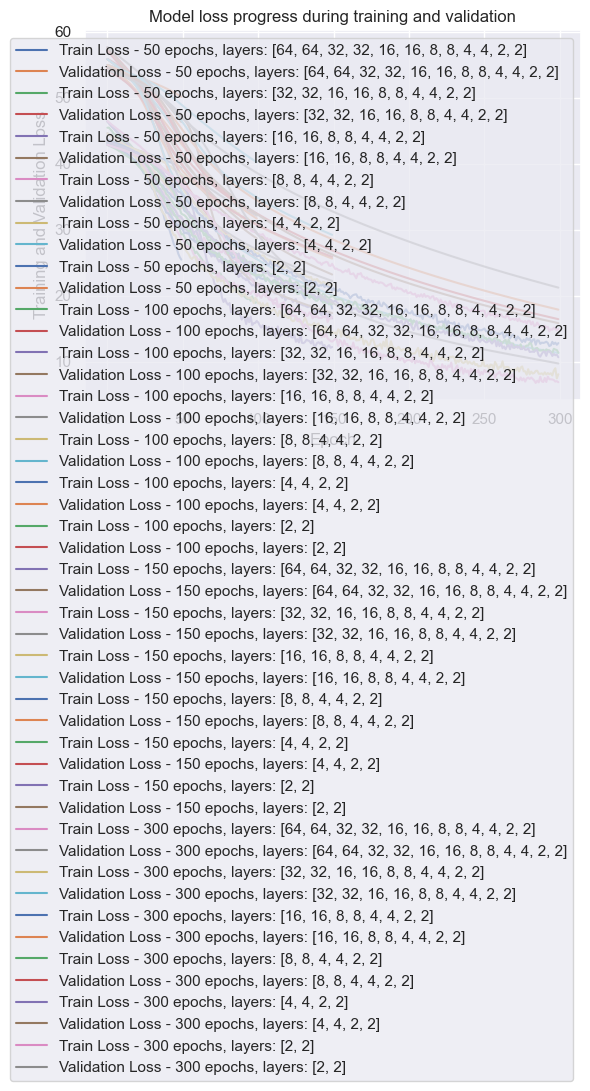

                                                    Train RMSE    Test RMSE
50 epochs, [64, 64, 32, 32, 16, 16, 8, 8, 4, 4,...  765.056932  2629.813071
50 epochs, [32, 32, 16, 16, 8, 8, 4, 4, 2, 2] l...  768.094386  2632.356091
50 epochs, [16, 16, 8, 8, 4, 4, 2, 2] layers        768.415829  2632.624912
50 epochs, [8, 8, 4, 4, 2, 2] layers                767.993271  2632.269820
50 epochs, [4, 4, 2, 2] layers                      768.132625  2632.386241
50 epochs, [2, 2] layers                            768.869902  2632.999191
100 epochs, [64, 64, 32, 32, 16, 16, 8, 8, 4, 4...  760.000033  2625.579974
100 epochs, [32, 32, 16, 16, 8, 8, 4, 4, 2, 2] ...  762.695518  2627.836250
100 epochs, [16, 16, 8, 8, 4, 4, 2, 2] layers       764.727930  2629.537328
100 epochs, [8, 8, 4, 4, 2, 2] layers               767.424554  2631.794941
100 epochs, [4, 4, 2, 2] layers                     764.586158  2629.418605
100 epochs, [2, 2] layers                           764.993733  2629.743418
150 epochs, 

In [88]:
# Normalize dataset for LSTM
# Transform 'RATE' using log transformation
rate_log_transformed = normalize_data_log(agg_df[['Rate']])

# Concatenate the log transformed data
dataset = np.concatenate([rate_log_transformed], axis=1)

# Split into train and test sets
train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]

# Reshape into X=t and Y=t+1, timestep  look_back
look_back = 5
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# Reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], look_back, trainX.shape[2]))
testX = np.reshape(testX, (testX.shape[0], look_back, testX.shape[2]))

epochs_list = [50, 100, 150, 300]

lstm_layers_list = [
    [64, 64, 32, 32, 16, 16, 8, 8, 4, 4, 2, 2],
    [32, 32, 16, 16, 8, 8, 4, 4, 2, 2],
    [16, 16, 8, 8, 4, 4, 2, 2],
    [8, 8, 4, 4, 2, 2],
    [4, 4, 2, 2],
    [2, 2]
]

rmse_results = {}

for epochs in epochs_list:
    print(f'Training for {epochs} epochs...')

    for lstm_layers in lstm_layers_list:
        print(f'Training with LSTM layers: {lstm_layers}')
        model, history = create_LSTM_model(
            trainX, trainY, testX, testY, epochs, lstm_layers)

        # Add the loss for this model to the plot
        plt.plot(
            history.history['loss'], label=f'Train Loss - {epochs} epochs, layers: {lstm_layers}')
        plt.plot(history.history['val_loss'],
                 label=f'Validation Loss - {epochs} epochs, layers: {lstm_layers}')

        # Predict LSTM Model
        trainPredict = model.predict(trainX)
        testPredict = model.predict(testX)

        # Inverse transform
        trainPredict = inverse_normalize_data_log(trainPredict)
        trainY_orig = inverse_normalize_data_log([trainY])
        testPredict = inverse_normalize_data_log(testPredict)
        testY_orig = inverse_normalize_data_log([testY])

        # Calculate mean squared error
        trainScore = calculate_RMSE(trainY_orig[0], trainPredict[:, 0])
        print(f'Train Score: {trainScore:.2f} RMSE for {epochs} epochs')
        testScore = calculate_RMSE(testY_orig[0], testPredict[:, 0])
        print(f'Test Score: {testScore:.2f} RMSE for {epochs} epochs')

        rmse_results[f'{epochs} epochs, {lstm_layers} layers'] = {
            'Train RMSE': trainScore, 'Test RMSE': testScore}

# Configure and show the plot
plt.title('Model loss progress during training and validation')
plt.xlabel('Epoch')
plt.ylabel('Training and Validation Loss')
plt.legend()
plt.show()

# Convert the dictionary to a DataFrame for easy display
rmse_df = pd.DataFrame(rmse_results).T
print(rmse_df)


<h4>Forecast the results</h4>

In [89]:
# Add check for 'RATE_actual' values to avoid division by zero
def compute_accuracy(row):
    if row['RATE_actual'] == 0:
        return np.nan
    else:
        error = abs(row['RATE_actual'] - row['RATE_forecasted'])
        error_proportion = error / row['RATE_actual']
        return (1 - error_proportion) * 100


def forecast_next_weeks(model, look_back, last_values, n_weeks):
    forecast = []
    for _ in range(n_weeks):
        last_values_2d = np.array(last_values[-look_back:]).reshape(-1, 1)
        input_values = np.log1p(last_values_2d)
        input_values = input_values.reshape((1, look_back, 1))

        prediction = model.predict(input_values)
        prediction = np.expm1(prediction)
        forecast.append(prediction[0][0])
        last_values.append(prediction[0][0])

    return forecast



In [90]:
weeks = 12

# Ensure that 'YearMonthWeek' is a datetime object
agg_df['YearMonthWeek'] = pd.to_datetime(agg_df['YearMonthWeek'])
last_date = agg_df['YearMonthWeek'].iloc[-1]

last_values = list(agg_df['Rate'].values[-look_back:])
forecasted_values = forecast_next_weeks(model, look_back, last_values, weeks)
forecasted_dates = pd.date_range(start=last_date, periods=weeks+1, freq='W')[1:]

df_forecasted = pd.DataFrame({
    'POD': forecasted_dates,
    'RATE': forecasted_values
})

df_forecasted["RATE"] = df_forecasted["RATE"].round(2)

df_forecasted.head(5)
df_forecasted.tail(5)
df_forecasted.info()

1/1 [==============================] - 0s 20ms/step


,POD,RATE
0,2023-02-26,73.839996
1,2023-03-05,73.580002
2,2023-03-12,73.510002
3,2023-03-19,73.480003
4,2023-03-26,73.440002


,POD,RATE
7,2023-04-16,73.339996
8,2023-04-23,73.339996
9,2023-04-30,73.339996
10,2023-05-07,73.339996
11,2023-05-14,73.339996


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   POD     12 non-null     datetime64[ns]
 1   RATE    12 non-null     float32       
dtypes: datetime64[ns](1), float32(1)
memory usage: 272.0 bytes


<h4>Comparing with actual updated against forecasted</h4>

In [91]:
comparison_df = pd.DataFrame(
    columns=['WeekStart', 'WeekEnd', 'POD_actual', 'RATE_forecasted', 'RATE_actual'])
df_forecasted['WeekEnd'] = df_forecasted['POD'] + pd.to_timedelta(7, unit='d')

for _, row in df_forecasted.iterrows():
    mask = (new_dates_df['POD'] >= row['POD']) & (
        new_dates_df['POD'] < row['WeekEnd'])
    actual_dates_within_week = new_dates_df[mask]

    for _, actual_row in actual_dates_within_week.iterrows():
        comparison_df = comparison_df.append({
            'WeekStart': row['POD'],
            'WeekEnd': row['WeekEnd'],
            'POD_actual': actual_row['POD'],
            'RATE_forecasted': row['RATE'],
            'RATE_actual': actual_row['RATE']
        }, ignore_index=True)

# Remove duplicates
comparison_df = comparison_df.drop_duplicates(
    subset=['POD_actual', 'RATE_forecasted', 'RATE_actual']).reset_index(drop=True)

# Compute accuracy
comparison_df['accuracy'] = comparison_df.apply(compute_accuracy, axis=1)
comparison_df = comparison_df.dropna(subset=['accuracy'])

total_mean_accuracy = comparison_df['accuracy'].mean()
comparison_df
print(f'The mean accuracy is {total_mean_accuracy:.2f}%\n')


C:\Users\Aloysius Wong\AppData\Local\Temp\ipykernel_43872\2511611426.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comparison_df = comparison_df.append({
C:\Users\Aloysius Wong\AppData\Local\Temp\ipykernel_43872\2511611426.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comparison_df = comparison_df.append({
C:\Users\Aloysius Wong\AppData\Local\Temp\ipykernel_43872\2511611426.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comparison_df = comparison_df.append({
C:\Users\Aloysius Wong\AppData\Local\Temp\ipykernel_43872\2511611426.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comparison_df = comparison_df.append({


,WeekStart,WeekEnd,POD_actual,RATE_forecasted,RATE_actual,accuracy
0,2023-02-26,2023-03-05,2023-03-02,73.839996,1000.0,7.384000
1,2023-03-05,2023-03-12,2023-03-10,73.580002,1000.0,7.358000
2,2023-03-12,2023-03-19,2023-03-16,73.510002,1000.0,7.351000
3,2023-03-19,2023-03-26,2023-03-21,73.480003,600.0,12.246667
4,2023-03-26,2023-04-02,2023-03-26,73.440002,600.0,12.240000
5,2023-03-26,2023-04-02,2023-03-31,73.440002,650.0,11.298462
6,2023-04-02,2023-04-09,2023-04-06,73.339996,650.0,11.283076
7,2023-04-09,2023-04-16,2023-04-13,73.339996,650.0,11.283076
8,2023-04-16,2023-04-23,2023-04-20,73.339996,650.0,11.283076
9,2023-04-23,2023-04-30,2023-04-28,73.339996,500.0,14.667999


The mean accuracy is 11.85%



<h4>Visualise all, Conclusion</h4>

<Figure size 2000x1000 with 0 Axes>

Text(0.5, 0, 'Date(Year Month)')

Text(0, 0.5, 'Cost Rate(USD)')

Text(0.5, 1.0, 'Port_BUSAN_Size_40_Type_HC_PartyID_010004286')

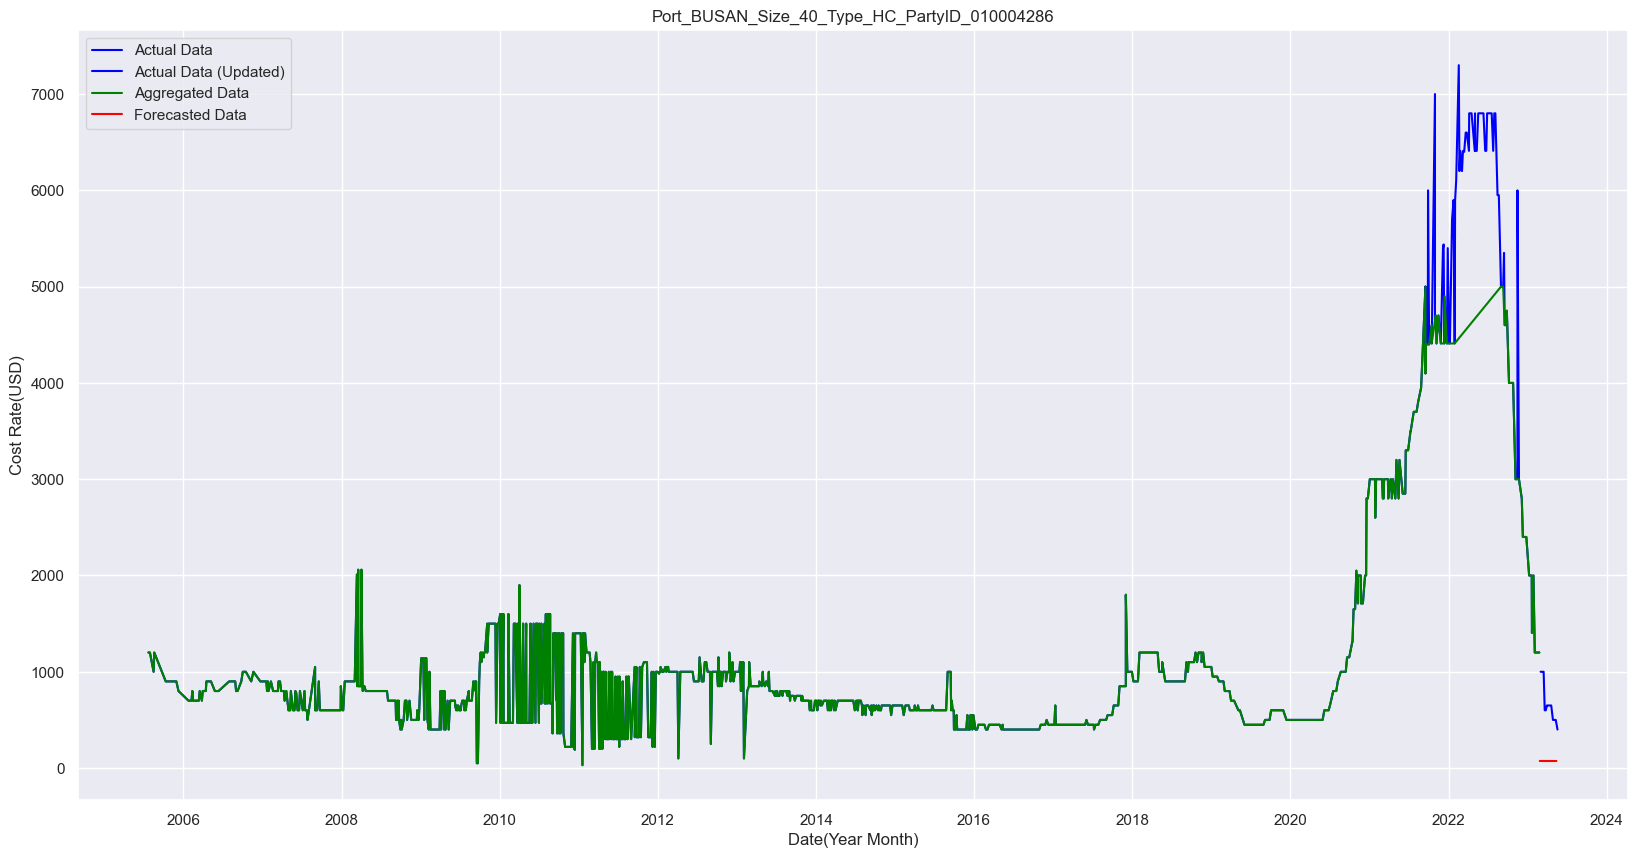

In [92]:
plt.figure(figsize=(20, 10))
plt.plot(sel_df['POD'], sel_df['RATE'], color='blue', label="Actual Data")
plt.plot(new_dates_df['POD'], new_dates_df['RATE'],
         color='blue', label="Actual Data (Updated)")

plt.plot(df_interpolated['POD'], df_interpolated['RATE'],
         color='green', label="Aggregated Data")
plt.plot(df_forecasted['POD'], df_forecasted['RATE'],
         color='red', label="Forecasted Data")

plt.xlabel('Date(Year Month)')
plt.ylabel('Cost Rate(USD)')
plt.title('Port_BUSAN_Size_40_Type_HC_PartyID_010004286')
plt.legend()
plt.show()
